In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torchmetrics as tm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from pathlib import Path
from scipy.io import loadmat
from torchvision.models import resnet50
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
from PIL import Image

In [2]:
# Constants
DATA_PATH = Path("../../data")
ANNOTATION_TRAIN = DATA_PATH / "cars_train_annos.mat"
TRAIN_PATH = DATA_PATH / "cars_train"

## Loading annotation data in matlab format

In [3]:
classes_data = [x[0] for x in loadmat(DATA_PATH / "devkit/cars_meta.mat")["class_names"][0]]
classes_data = {k: v for k, v in enumerate(classes_data)}
for idx, (k, v) in enumerate(classes_data.items()):
    if idx > 10:
        break
    print(k, ":", v)

0 : AM General Hummer SUV 2000
1 : Acura RL Sedan 2012
2 : Acura TL Sedan 2012
3 : Acura TL Type-S 2008
4 : Acura TSX Sedan 2012
5 : Acura Integra Type R 2001
6 : Acura ZDX Hatchback 2012
7 : Aston Martin V8 Vantage Convertible 2012
8 : Aston Martin V8 Vantage Coupe 2012
9 : Aston Martin Virage Convertible 2012
10 : Aston Martin Virage Coupe 2012


In [4]:
def annotations_preprocess(mat, path) -> pd.DataFrame:
    annotation = pd.DataFrame(mat["annotations"][0][['fname', 'class']])
    annotation['fname'] = annotation['fname'].apply(lambda x: x[0]).apply(lambda x: str(path / x))
    annotation['class'] = annotation['class'].astype(np.int16) - 1
    return annotation

In [5]:
annotation_train = annotations_preprocess(loadmat(ANNOTATION_TRAIN), TRAIN_PATH)

In [6]:
annotation_train.head()

,fname,class
0,../../data/cars_train/00001.jpg,13
1,../../data/cars_train/00002.jpg,2
2,../../data/cars_train/00003.jpg,90
3,../../data/cars_train/00004.jpg,133
4,../../data/cars_train/00005.jpg,105


In [7]:
annotation_train['class'].value_counts()

118    68
78     49
160    48
166    48
143    47
       ..
174    31
63     30
157    29
98     28
135    24
Name: class, Length: 196, dtype: int64

In [8]:
shapes = [read_image(p).shape for p in annotation_train['fname']]
annotation_train['shapes'] = shapes

In [9]:
annotation_train['shapes'] = annotation_train.shapes.apply(lambda x: x[0])

In [10]:
annotation_train = annotation_train[annotation_train['shapes'] == 3]
annotation_train.drop("shapes", axis=1, inplace=True)

In [12]:
annotation_train.to_parquet("annotation.parquet")

In [5]:
annotation_train = pd.read_parquet("annotation.parquet")

In [6]:
nr_of_classes = annotation_train['class'].nunique()

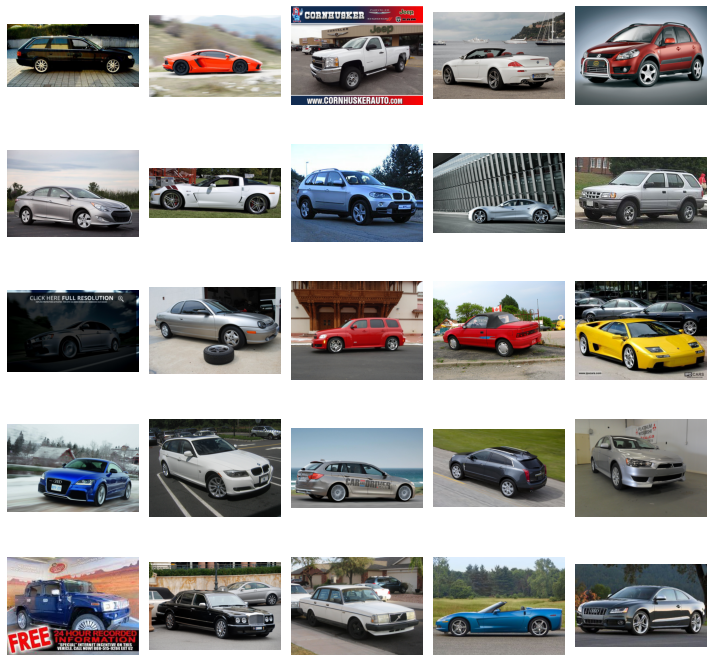

In [7]:
fig, ax = plt.subplots(5, 5, figsize=(10, 10))

for idx, plot_cell in enumerate(ax):
    for plot_row in plot_cell:
        plot_row.grid(False)
        plot_row.axis(False)
        index = np.random.randint(0, annotation_train.shape[0])
        im = read_image(annotation_train.iloc[index, 0]).permute(1, 2, 0)
        plot_row.imshow(im)
plt.tight_layout()

## Dataset and DataLoader

In [8]:
# Split the data
train_df, valid_df = train_test_split(annotation_train,
                                      test_size=0.2,
                                      random_state=123,
                                      shuffle=True,
                                      stratify=annotation_train['class'])

print(train_df.shape)
print(valid_df.shape)

(6500, 2)
(1626, 2)


In [9]:
train_df.reset_index(inplace=True)
valid_df.reset_index(inplace=True)
train_df.drop("index", axis=1, inplace=True)
valid_df.drop("index", axis=1, inplace=True)
train_df.head()

,fname,class
0,../../data/cars_train/00792.jpg,34
1,../../data/cars_train/05788.jpg,71
2,../../data/cars_train/05257.jpg,100
3,../../data/cars_train/07092.jpg,190
4,../../data/cars_train/07972.jpg,106


## Model building

In [10]:
class CarDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        self.img_df = df
        self.transform = transform

    def __len__(self):
        return len(self.img_df)

    def __getitem__(self, item):
        img_path = self.img_df.loc[item, "fname"]
        image = read_image(img_path)
        label = self.img_df.loc[item, "class"]
        if self.transform:
            image = self.transform(image)
        return image, label

In [15]:
class CarClassification(pl.LightningModule):
    def __init__(self, num_of_classes,
                 lr=1e-3, transfer=True,
                 tune_fc=True, hidden_layers=524,
                 optimizer=optim.Adam, batch_size=32):
        super(CarClassification, self).__init__()
        self.resnet = resnet50(pretrained=transfer)
        self.in_features = self.resnet.fc.in_features
        self.optimizer = optimizer
        self.criterion = nn.CrossEntropyLoss()
        self.lr = lr
        self.batch_size = batch_size
        if tune_fc:
            for name, param in self.resnet.named_parameters():
                if "bn" not in name:
                    param.requires_grad = False
        self.resnet.fc = nn.Sequential(
            nn.Linear(self.in_features, hidden_layers),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_layers, num_of_classes)
        )

    def forward(self, x):
        return self.resnet(x)

    def configure_optimizers(self):
        return self.optimizer(self.parameters(), lr=self.lr)

    def train_dataloader(self):
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomHorizontalFlip(0.3),
            transforms.RandomVerticalFlip(0.3),
            transforms.Lambda(lambda x: x / 255.)
        ])
        img_train = CarDataset(train_df, transform=transform)
        return DataLoader(img_train, batch_size=self.batch_size, shuffle=True)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.long()
        preds = self(x)
        loss = self.criterion(preds, y)
        max_vals, argmax = preds.max(-1)
        accuracy_metrics = tm.Accuracy()
        accuracy = accuracy_metrics(argmax, y).to(self.device)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_accuracy", accuracy, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def valid_dataloader(self):
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.Lambda(lambda x: x / 255.)
        ])
        img_val = CarDataset(valid_df, transform=transform)
        return DataLoader(img_val, batch_size=1, shuffle=False)

    def valid_step(self, batch, batch_idx):
        x, y = batch
        y = y.long()
        preds = self(x)
        max_vals, argmax = preds.max(-1)
        loss = self.criterion(preds, y)
        accuracy_metrics = tm.Accuracy()
        accuracy = accuracy_metrics(argmax, y).to(self.device)
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("valid_accuracy", accuracy, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

In [16]:
model = CarClassification(nr_of_classes)

In [17]:
trainer = pl.Trainer(gpus=1, max_epochs=3, progress_bar_refresh_rate=20)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [18]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | resnet    | ResNet           | 24.7 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
1.2 M     Trainable params
23.5 M    Non-trainable params
24.7 M    Total params
98.738    Total estimated model params size (MB)
/home/dauren/anaconda3/envs/cars/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [23]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Launching TensorBoard...